In [1]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import figure

In [2]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    opens = pd.DataFrame(dataframes[0].open).rename(columns={'open':labels[0]})
    for i,coin in enumerate(labels[1:]):
        temp_opens = pd.DataFrame(dataframes[i+1].open).rename(columns={'open':coin})
        opens = opens.merge(temp_opens,how='outer',on='timestamp')
    return (opens)

def load_crypto(days=1000,timeframe='1h',n=30):
    bnc = ccxt.binance()
    symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,since/1000)
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i,:]/price_arr[i-1,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i,:]/price_arr[i-1,:])
    log_returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

In [3]:
#loads and writes the data to csv
#opens=load_crypto()
#opens.to_csv('CryptoPrices')

In [4]:
opens = pd.read_csv('CryptoPrices').set_index("timestamp")
opens = opens.dropna(axis=0)
returns = get_returns(opens)
log_returns = get_log_returns(opens)

In [5]:
y = np.asarray(log_returns["BTC"])
X = np.asarray(log_returns.drop("BTC",axis=1))

Text(0.5, 1.0, 'Beta values of cryptocurrencies with respect to Bitcoin')

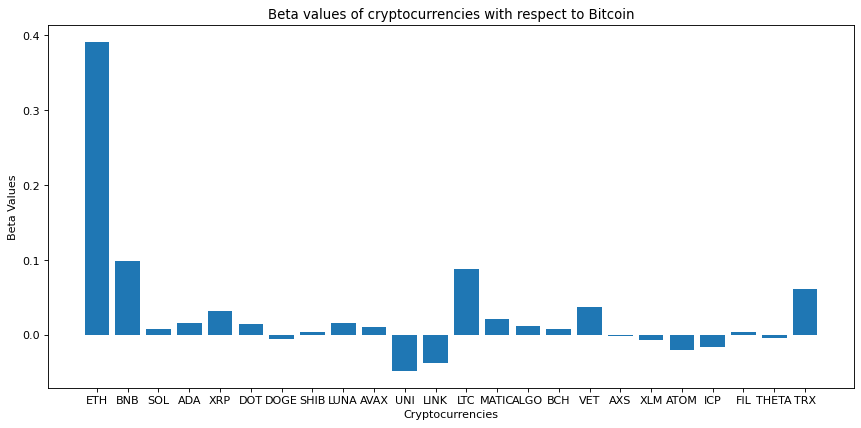

In [8]:
figure(figsize=(13, 6), dpi=80)
plt.bar(log_returns.columns[1:], coeff_df["Beta"])
plt.xlabel("Cryptocurrencies")
plt.ylabel("Beta Values")
plt.title("Beta values of cryptocurrencies with respect to Bitcoin")

Text(0, 0.5, 'Std Deviation of Hourly Log Returns')

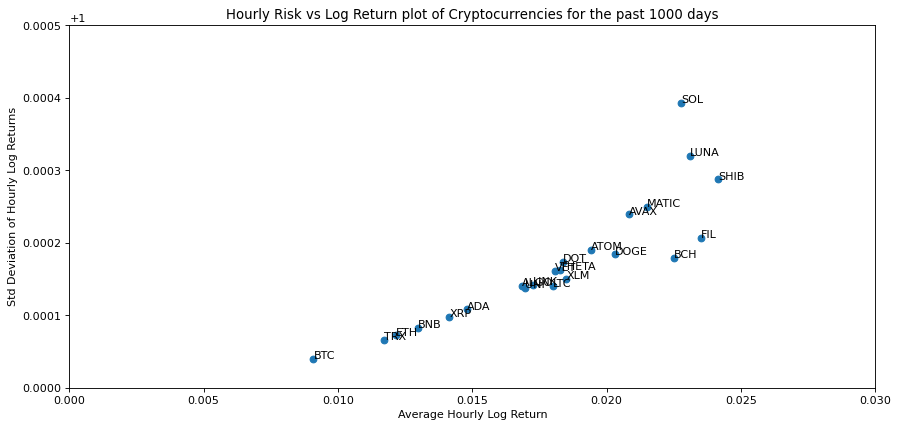

In [9]:
figure(figsize=(13, 6), dpi=80)
desc = np.asarray(log_returns.describe())[1,:]
std = np.asarray(log_returns.describe())[2,:]
plt.scatter(std,desc)
plt.xlim(0,.03)
plt.ylim(1,1.0005)
for i, txt in enumerate(log_returns.columns):
    plt.annotate(txt, (std[i], desc[i]))
plt.title("Hourly Risk vs Log Return plot of Cryptocurrencies for the past 1000 days")
plt.xlabel("Average Hourly Log Return")
plt.ylabel("Std Deviation of Hourly Log Returns")

Text(0, 0.5, 'Std Deviation of Hourly Log Returns')

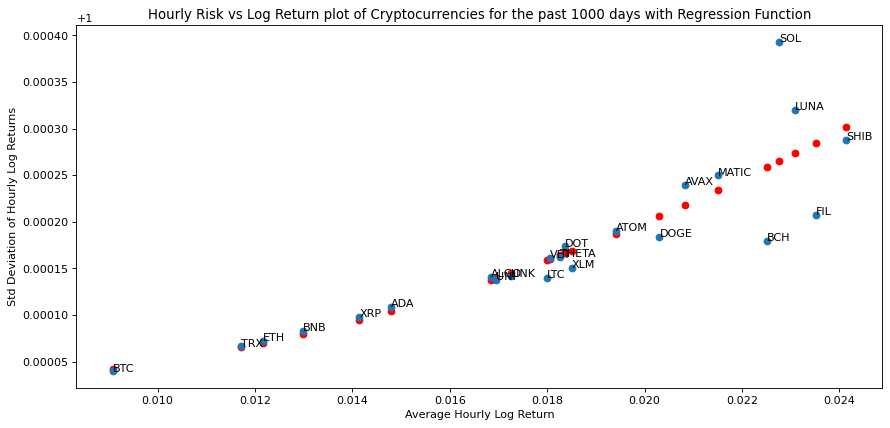

In [11]:
filtered = log_returns.describe().drop(columns=["AXS","ICP"])
desc = np.asarray(filtered)[1,:]
std = np.asarray(filtered)[2,:]

figure(figsize=(13, 6), dpi=80)
lm2 = LinearRegression()
std2 = np.ones([len(std),3])
std2[:,1] = std
std2[:,2] = std**2
lm2.fit(std2,desc.reshape(-1,1))
predictions = lm2.predict(std2)
plt.scatter(std, predictions,c='r')
plt.scatter(std,desc)
#plt.xlim(0,.03)
#plt.ylim(1,1.0005)
for i, txt in enumerate(filtered.columns):
    plt.annotate(txt, (std[i], desc[i]))
plt.title("Hourly Risk vs Log Return plot of Cryptocurrencies for the past 1000 days with Regression Function")
plt.xlabel("Average Hourly Log Return")
plt.ylabel("Std Deviation of Hourly Log Returns")

In [ ]:
lm2.coef_